### Курсовой проект Андрианова А.Ю. по теме _"Библиотеки Python для Data Science Numpy, Matplotlib, Scikit-learn"_

In [1]:
# !pip install lightgbm

In [2]:
# !pip install featuretools

In [3]:
# !pip install imblearn

In [4]:
# Загружает необходимые модули
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle


# Модели
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm

#Методы
import featuretools as ft
import featuretools.variable_types as vtypes
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

#  Метрики качества
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

#  Статистические критерии
from scipy.stats import chi2_contingency

In [5]:
# Путь к файлам
TRAINDATASET_PATH = './train.csv'
PREPARED_TRAINDATASET_PATH = './train_prepared.csv'

TESTDATASET_PATH = './test.csv'
PREPARED_TESTDATASET_PATH = './test_prepared.csv'
SUBMISSION_PATH = './submission.csv'

REPORTS_FILE_PATH = './reports/'
SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

## Обработка и визуализация данных

In [6]:
# Загрузим данные из обучающего датасета и посмотрим на них
df_train = pd.read_csv(TRAINDATASET_PATH, sep=',')
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [7]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В датасете присутстувует данные типа object, которые необходимо будет иззменить. Так же имеются признаки с отсутствующими данными, которые необходимо будет заполнить. 

#### Home Ownership

In [9]:
# Рассмотрим значения в Home Ownership и их количество
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Have Mortgage очень маленькое количество по сравнению с остальными значениями. Добавим их в Home Mortgage и переведём все значения в дами переменые.

In [10]:
df_train['Rent'] = 0
df_train['Own Home'] = 0
df_train['Mortgage'] = 0
df_train.loc[df_train['Home Ownership'] == 'Rent', 'Rent'] = 1
df_train.loc[df_train['Home Ownership'] == 'Own Home', 'Own Home'] = 1
df_train.loc[(df_train['Home Ownership'] == 'Home Mortgage') | (df_train['Home Ownership'] == 'Have Mortgage'), 'Mortgage'] = 1
df_train = df_train.drop(columns='Home Ownership')

#### Years in current job

In [11]:
# Посмотрим на значения в стаже работы
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Заменим описания стада работы на просто цифровую информацию об отработаном количестве лет, при этом < 1 year заменим на 0, а 10+ years просто 10.

In [12]:
df_train.loc[df_train['Years in current job'] == '< 1 year', 'Years in current job'] = 0
df_train.loc[df_train['Years in current job'] == '1 year', 'Years in current job'] = 1
df_train.loc[df_train['Years in current job'] == '2 years', 'Years in current job'] = 2
df_train.loc[df_train['Years in current job'] == '3 years', 'Years in current job'] = 3
df_train.loc[df_train['Years in current job'] == '4 years', 'Years in current job'] = 4
df_train.loc[df_train['Years in current job'] == '5 years', 'Years in current job'] = 5
df_train.loc[df_train['Years in current job'] == '6 years', 'Years in current job'] = 6
df_train.loc[df_train['Years in current job'] == '7 years', 'Years in current job'] = 7
df_train.loc[df_train['Years in current job'] == '8 years', 'Years in current job'] = 8
df_train.loc[df_train['Years in current job'] == '9 years', 'Years in current job'] = 9
df_train.loc[df_train['Years in current job'] == '10+ years', 'Years in current job'] = 10
df_train['Years in current job'] = df_train['Years in current job'].astype(np.float64)
df_train['Years in current job'].median()

6.0

Заменим отсутствующие данные на медианые.

In [13]:
med_years = df_train['Years in current job'].median()
df_train.loc[df_train['Years in current job'].isna(), 'Years in current job'] = med_years

#### Purpose

In [14]:
# Расмотрим значения в Purpose
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

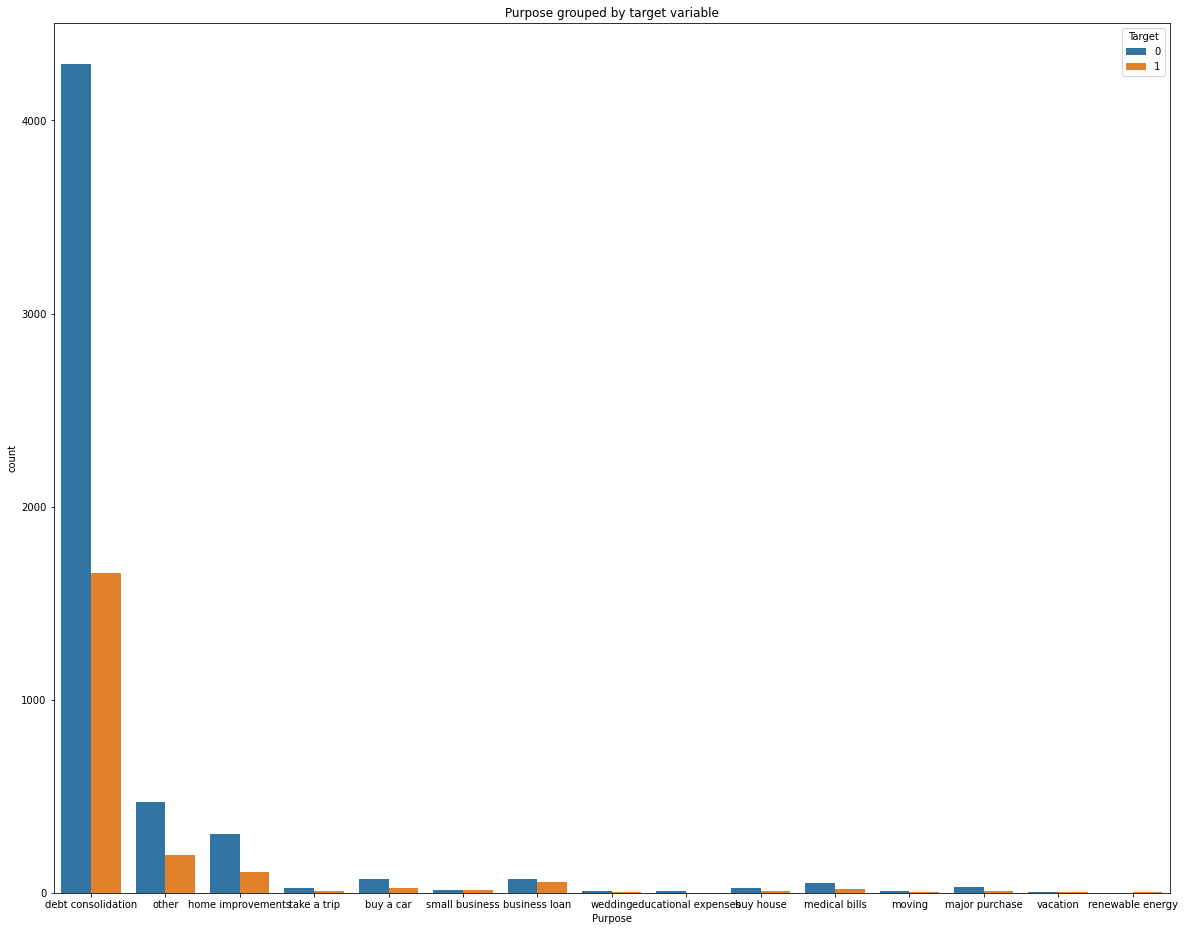

In [15]:
plt.figure(figsize=(20, 16))

sns.countplot(x="Purpose", hue='Credit Default', data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Из графика видно что количества debt consolidation намного привышает остальные значения. Так же относительное количество числа дефолтов у business loan и small business значительно больше чем в других. Проверим похоже ли они.

In [16]:
df_train['Id'] = df_train.index
business_purpose = df_train.loc[(df_train['Purpose'] == 'business loan') | 
                                (df_train['Purpose'] == 'small business'), ['Id', 'Purpose', 'Credit Default']]
business_table = business_purpose.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(business_table)
p

0.40483403834216214

0.40 > 0.05 Значет их можно объединить.

home improvements, buy house и moving имеют схожий логический смысл. Так же проверим их.

In [17]:
mortgage_purpose = df_train.loc[ (df_train['Purpose'] == 'home improvements') |
                                  (df_train['Purpose'] == 'buy house') |
                                 (df_train['Purpose'] == 'moving'), ['Id', 'Purpose', 'Credit Default']]
mortgage_table = mortgage_purpose.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(mortgage_table)
p

0.8342602566924932

Критерий Хи-квадрат равен почти 1 что означают они очень похожи.

Из Purpose можно сделать четыре дамми переменые. Debt consolidation где будут указаны debt consolidation, Business c business loan и small business, Buying home где будет указаны home improvements, buy house и moving, Others с остаными значениями.     

In [18]:
df_train['Debt consolidation'] = 0
df_train['Business'] = 0
df_train['Buying home'] = 0
df_train['Others'] = 0
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Debt consolidation'] = 1
df_train.loc[(df_train['Purpose'] == 'business loan') | (df_train['Purpose'] == 'small business'), 'Business'] = 1
df_train.loc[(df_train['Purpose'] == 'home improvements') | (df_train['Purpose'] == 'buy house') |
             (df_train['Purpose'] == 'moving'), 'Buying home'] = 1
df_train.loc[(df_train['Purpose'] == 'other') | (df_train['Purpose'] == 'take a trip') | 
             (df_train['Purpose'] == 'buy a car') | (df_train['Purpose'] == 'moving') | 
             (df_train['Purpose'] == 'wedding') | (df_train['Purpose'] == 'educational expenses') | 
             (df_train['Purpose'] == 'medical bills') | (df_train['Purpose'] == 'major purchase') | 
             (df_train['Purpose'] == 'vacation') | (df_train['Purpose'] == 'renewable energy'), 'Others'] = 1
df_train = df_train.drop(columns='Purpose')
df_train = df_train.drop(columns='Id')

#### Term

In [19]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

Заменим Short Term на 0, а Long Term на 1

In [20]:
df_train['Term_changed'] = 0
df_train.loc[df_train['Term'] == 'Long Term', 'Term_changed'] = 1
df_train = df_train.drop(columns='Term')

#### Tax Liens

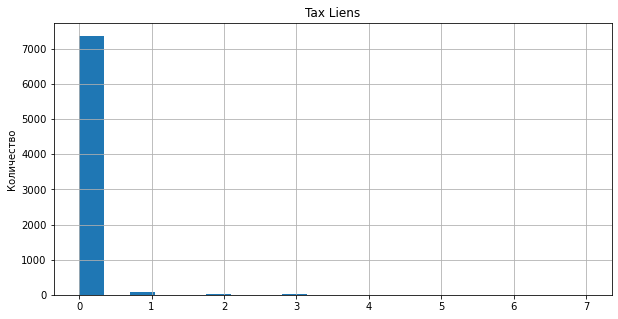

In [21]:
plt.figure(figsize = (10, 5))

df_train['Tax Liens'].hist(bins=20)
plt.ylabel('Количество')


plt.title('Tax Liens')
plt.show()

In [22]:
(df_train.loc[df_train['Tax Liens'] == 0, 'Tax Liens'].count())/df_train['Tax Liens'].count()

0.9821333333333333

Более 98% данных имеют нулевые значения в Tax Liens, этот параметры будет иметь незначительный вес в обучении модели и его можно удалить.

In [23]:
df_train = df_train.drop(columns='Tax Liens')

#### Number of Open Accounts

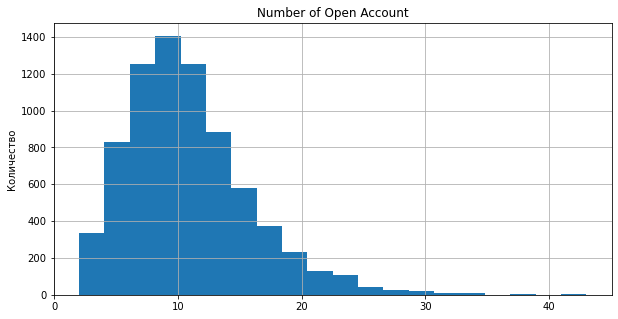

In [24]:
plt.figure(figsize = (10, 5))

df_train['Number of Open Accounts'].hist(bins=20)
plt.ylabel('Количество')


plt.title('Number of Open Account')
plt.show()

На графике видин длиный "хвост" страва, вероятно это выбросы. Заменим эти данные на медианные значения.

In [25]:
account_qauant = df_train['Number of Open Accounts'].quantile(q=0.99)
account_qauant

27.0

In [26]:
med_account = df_train['Number of Open Accounts'].median()
df_train.loc[df_train['Number of Open Accounts'] > account_qauant, 'Number of Open Accounts'] = med_account

#### Years of Credit History

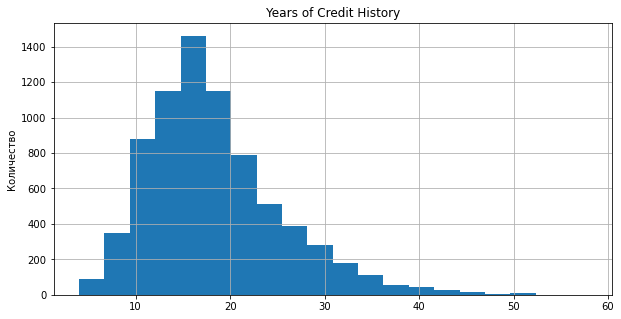

In [27]:
plt.figure(figsize = (10, 5))

df_train['Years of Credit History'].hist(bins=20)
plt.ylabel('Количество')


plt.title('Years of Credit History')
plt.show()

По графиику выбросов не наблюдается. "Хвост" данный в правой часте может соответствовать пожилым клиентам и не привышает продолжительность жизни людей. Хоть в данных выбросах и не наблюдается, ограничем диапазод данных.

In [28]:
df_train['Years of Credit History'] = np.clip(df_train['Years of Credit History'], a_min=0, a_max=70) 

#### Number of Credit Problems

In [29]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

Число проблемных кредитов не значительно, можно удалить этот признак

In [30]:
df_train = df_train.drop(columns='Number of Credit Problems')

#### Months since last delinquent

In [31]:
# Заполним пропуски в Months since last delinquent медианными значениями
med_delinquent = df_train['Months since last delinquent'].median()
df_train.loc[df_train['Months since last delinquent'].isna(), 'Months since last delinquent'] = med_delinquent

##### Bankruptcies

In [32]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Количество банкротств не существено. Можно убрать этотот параметр.

In [33]:
df_train = df_train.drop(columns='Bankruptcies')

#### Credit Score

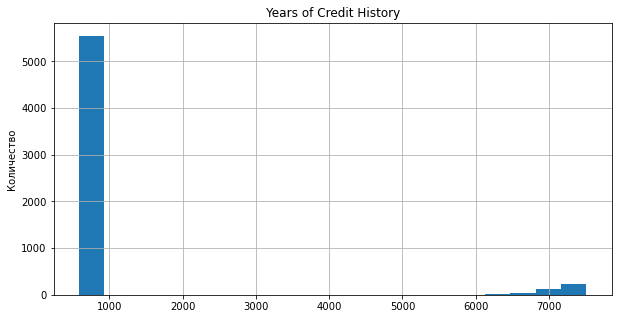

In [34]:
plt.figure(figsize = (10, 5))

df_train['Credit Score'].hist(bins=20)
plt.ylabel('Количество')


plt.title('Years of Credit History')
plt.show()

In [35]:
df_train.loc[df_train['Credit Score'] > 1000 , 'Credit Score'].head()

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
Name: Credit Score, dtype: float64

На графике видно что основные данные сосредаточены на участке от 0 до 1000, а далее идет пробел и они возобновляются около 7000, эти данные кратны 10. вероятнее всего была ошибка ввода. Разделим этот участок на 10.

In [36]:
df_train.loc[df_train['Credit Score'] > 1000 , 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 1000 , 'Credit Score'] /10

In [37]:
# Заполним оставшиеся пропуски в Credit Score медианными значениями
med_score = df_train['Credit Score'].median()
df_train.loc[df_train['Credit Score'].isna(), 'Credit Score'] = med_score

#### Annual Income

In [38]:
# Заполним пропуски в Annual Income медианными значениями
med_annual = df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isna(), 'Annual Income'] = med_annual

# Test dataset 

In [39]:
df_test = pd.read_csv(TESTDATASET_PATH, sep=',')
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [40]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


In [41]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Обработаем тестовые данные по томуже принцепу что и трейн датасет

#### Home Ownership

In [42]:
df_test['Rent'] = 0
df_test['Own Home'] = 0
df_test['Mortgage'] = 0
df_test.loc[df_test['Home Ownership'] == 'Rent', 'Rent'] = 1
df_test.loc[df_test['Home Ownership'] == 'Own Home', 'Own Home'] = 1
df_test.loc[(df_test['Home Ownership'] == 'Home Mortgage') | (df_test['Home Ownership'] == 'Have Mortgage'), 'Mortgage'] = 1
df_test = df_test.drop(columns='Home Ownership')

#### Years in current job

In [43]:
df_test.loc[df_test['Years in current job'] == '< 1 year', 'Years in current job'] = 0
df_test.loc[df_test['Years in current job'] == '1 year', 'Years in current job'] = 1
df_test.loc[df_test['Years in current job'] == '2 years', 'Years in current job'] = 2
df_test.loc[df_test['Years in current job'] == '3 years', 'Years in current job'] = 3
df_test.loc[df_test['Years in current job'] == '4 years', 'Years in current job'] = 4
df_test.loc[df_test['Years in current job'] == '5 years', 'Years in current job'] = 5
df_test.loc[df_test['Years in current job'] == '6 years', 'Years in current job'] = 6
df_test.loc[df_test['Years in current job'] == '7 years', 'Years in current job'] = 7
df_test.loc[df_test['Years in current job'] == '8 years', 'Years in current job'] = 8
df_test.loc[df_test['Years in current job'] == '9 years', 'Years in current job'] = 9
df_test.loc[df_test['Years in current job'] == '10+ years', 'Years in current job'] = 10
df_test['Years in current job'] =df_test['Years in current job'].astype(np.float32)

In [44]:
# Заменим отсутствующие данные на медианые данные из трайн датасета.
df_test.loc[df_test['Years in current job'].isna(), 'Years in current job'] = med_years

#### Purpose

In [45]:
# Расмотрим значения в Purpose
df_test['Purpose'].unique()

array(['debt consolidation', 'educational expenses', 'home improvements',
       'major purchase', 'other', 'buy a car', 'medical bills',
       'buy house', 'business loan', 'take a trip', 'small business',
       'moving', 'vacation', 'wedding'], dtype=object)

In [46]:
df_test['Debt consolidation'] = 0
df_test['Business'] = 0
df_test['Buying home'] = 0
df_test['Others'] = 0
df_test.loc[df_test['Purpose'] == 'debt consolidation', 'Debt consolidation'] = 1
df_test.loc[(df_test['Purpose'] == 'business loan') | (df_test['Purpose'] == 'small business'), 'Business'] = 1
df_test.loc[(df_test['Purpose'] == 'home improvements') | (df_test['Purpose'] == 'buy house') |
             (df_test['Purpose'] == 'moving'), 'Buying home'] = 1
df_test.loc[(df_test['Purpose'] == 'other') | (df_test['Purpose'] == 'take a trip') | 
             (df_test['Purpose'] == 'buy a car') | (df_test['Purpose'] == 'moving') | 
             (df_test['Purpose'] == 'wedding') | (df_test['Purpose'] == 'educational expenses') | 
             (df_test['Purpose'] == 'medical bills') | (df_test['Purpose'] == 'major purchase') | 
             (df_test['Purpose'] == 'vacation') | (df_test['Purpose'] == 'renewable energy'), 'Others'] = 1
df_test = df_test.drop(columns='Purpose')

#### Term

In [47]:
df_test['Term_changed'] = 0
df_test.loc[df_test['Term'] == 'Long Term', 'Term_changed'] = 1
df_test = df_test.drop(columns='Term')

#### Months since last delinquent

In [48]:
# Заполним пропуски в Months since last delinquent медианными значениями
df_test.loc[df_test['Months since last delinquent'].isna(), 'Months since last delinquent'] = med_delinquent

#### Tax Liens

In [49]:
df_test = df_test.drop(columns='Tax Liens')

#### Number of Open Accounts

In [50]:
df_test.loc[df_test['Number of Open Accounts'] > account_qauant, 'Number of Open Accounts'] = med_account

#### Number of Credit Problems

In [51]:
df_test = df_test.drop(columns='Number of Credit Problems')

##### Bankruptcies

In [52]:
df_test = df_test.drop(columns='Bankruptcies')

#### Credit Score

In [53]:
df_test.loc[df_test['Credit Score'] > 1000 , 'Credit Score'] = df_test.loc[df_test['Credit Score'] > 1000 , 'Credit Score'] /10

In [54]:
# Заполним пропуски в Credit Score медианными значениями
df_test.loc[df_test['Credit Score'].isna(), 'Credit Score'] = med_score

#### Annual Income

In [55]:
# Заполним пропуски в Annual Income медианными значениями
df_test.loc[df_test['Annual Income'].isna(), 'Annual Income'] = med_annual

# Балансеровка классов

Балансеровку классов сначала сделаем методом Tomek Links для лучшего раделения классов, потом методом SMOTE для уравненвания их количества.

In [56]:
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_sample(df_train.drop(columns='Credit Default'), df_train['Credit Default'])
df_train = pd.concat([X_tomek, y_tomek], axis=1)

smote = SMOTE()
X_smote, y_smote = smote.fit_sample(df_train.drop(columns='Credit Default'), df_train['Credit Default'])
df_train = pd.concat([X_smote, y_smote], axis=1)

# Обучение модели

In [57]:
# Разобьём датасет для обучения модели.
X_train = df_train.drop(columns='Credit Default')
y_train = df_train['Credit Default']

In [58]:
# Сделаем функциию для проверки различных моделей
def checking_models(X, y):
    # Логистическая регрессия
    model_lr = LogisticRegression()
    model_lr.fit(X, y)
    cv_score = cross_val_score(model_lr, X, y, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=37))

    print(f"Линенйная регрессия\nf1 = {round(cv_score.mean(), 3)}")
    
    #Метод ближайших соседий
    model_knn = KNeighborsClassifier()
    model_knn.fit(X_train, y_train)

    cv_score = cross_val_score(model_knn, X, y, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=37))
    print(f"Метод ближайших соседий\nf1 = {round(cv_score.mean(), 3)}")
    
    # Дерево решений
    dt_model = DecisionTreeClassifier(random_state=74)

    params_tree = {'max_depth':[9, 10, 11],
                  'min_samples_leaf':[10, 11, 12]
                  }

    gs_tree = GridSearchCV(dt_model, params_tree, 
                          scoring='f1', # метрика 
                          cv=KFold(n_splits=3,  # k кол-во разбиений в кросс-валидации
                                   random_state=37, 
                                   shuffle=True),
                          n_jobs=-1
                          )
    gs_tree.fit(X, y)
    print(f"\nДерево решений\nЛучшее параметры = {gs_tree.best_params_}\nf1 = {round(gs_tree.best_score_, 3)}")
    
     
    # LightGBM   
    model_lgbm = lgbm.LGBMClassifier(random_state=74)
    params_boost = {'n_estimators':[290, 300, 310], 
                    'max_depth':[4, 5, 6],
                    'num_leaves':[10, 11, 12],
                    'reg_lambda':[0.8, 0.9, 1]
                    }

    model_lgbm = GridSearchCV(model_lgbm, params_boost, 
                      scoring='f1', 
                      cv=KFold(n_splits=3,   
                               random_state=37, 
                               shuffle=True),
                      n_jobs=-1
                      )
    model_lgbm.fit(X, y)
    print(f"\nLightGBM \nЛучшее параметры = {model_lgbm.best_params_}\nf1 = {round(model_lgbm.best_score_, 3)}")

In [59]:
#checking_models(X_train, y_train)

Линенйная регрессия f1 = 0.697

Метод ближайших соседий f1 = 0.737

Дерево решений f1 = 0.729

Лучшее параметры = {'max_depth': 11, 'min_samples_leaf': 10}

LightGBM f1 = 0.799

Лучшее параметры = {'max_depth': 5, 'n_estimators': 290, 'num_leaves': 11, 'reg_lambda': 1}


Лучшая модель оказалась LightGBM 

In [60]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [61]:
model_lgbm = lgbm.LGBMClassifier(random_state=74, 
                               class_weight={0:1, 1:2},
                                n_estimators=290,
                                num_leaves=11,
                                max_depth=5,
                                reg_lambda=1 
                                )
model_lgbm.fit(X_train, y_train)

cv_score = cross_val_score(model_lgbm, X_train, y_train, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=37))
print(cv_score)
print(round(cv_score.mean(), 5))

[0.75669244 0.77141204 0.76228801]
0.76346


In [62]:
y_train_pred_probs = model_lgbm.predict_proba(X_train)

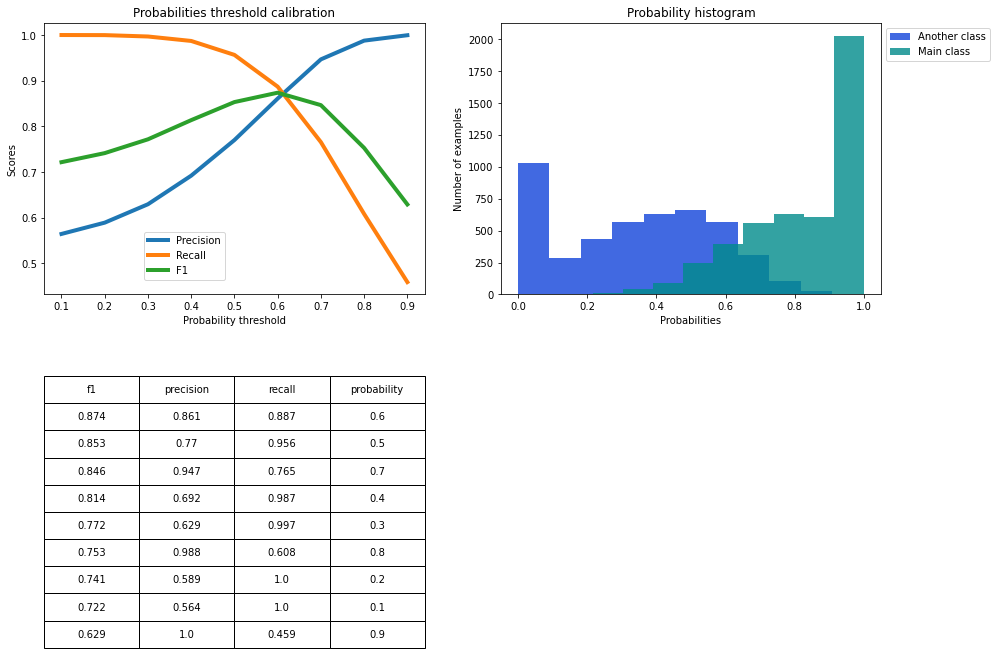

In [63]:
show_proba_calibration_plots(y_train_pred_probs[:, 1], y_train)

# Предсказание класса

In [64]:
y_test_preds = model_lgbm.predict(df_test)
y_test_preds

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [65]:
df_sumbission = pd.DataFrame({'Id': df_test.index, 'Credit Default': y_test_preds})
df_sumbission

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,1


In [66]:
df_sumbission.to_csv(SUBMISSION_PATH, index=False, encoding='utf-8', sep=',')